In [5]:
import pandas as pd
import numpy as np
import math
from scipy.stats import weibull_min, invweibull, uniform, norm
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from pylab import rcParams

import seaborn as sns

import helpers

sns.set()

rcParams['figure.figsize'] = 20,20

# Create the P function from matlab
data = np.loadtxt("powermat.csv", delimiter=",")
x = np.arange(0,30,0.001)
P = interp1d(x,data, fill_value="extrapolate")

# Creating lambda function allowing faster calculations
calculate_power = lambda x: P(x)
#_ = plt.plot(x,P(x))

n = 100000

hlp = helpers.helper_methods(n)
hlp.init_winds()

# 2 a)

\begin{tabular}{ll}
\toprule
{} &                  Mean \\
Month &                       \\
\midrule
jan   &  1734469.31 ± 7582.51 \\
feb   &  1572712.22 ± 7520.87 \\
mar   &  1468630.86 ± 7447.41 \\
apr   &   1189206.2 ± 7095.81 \\
may   &  1143038.84 ± 6986.18 \\
jun   &  1208879.94 ± 7149.22 \\
jul   &  1141963.97 ± 6996.22 \\
aug   &  1213981.63 ± 7160.75 \\
sep   &  1447633.07 ± 7414.15 \\
oct   &  1586619.06 ± 7632.47 \\
nov   &  1736415.99 ± 7588.25 \\
dec   &  1731150.99 ± 7594.82 \\
\bottomrule
\end{tabular}



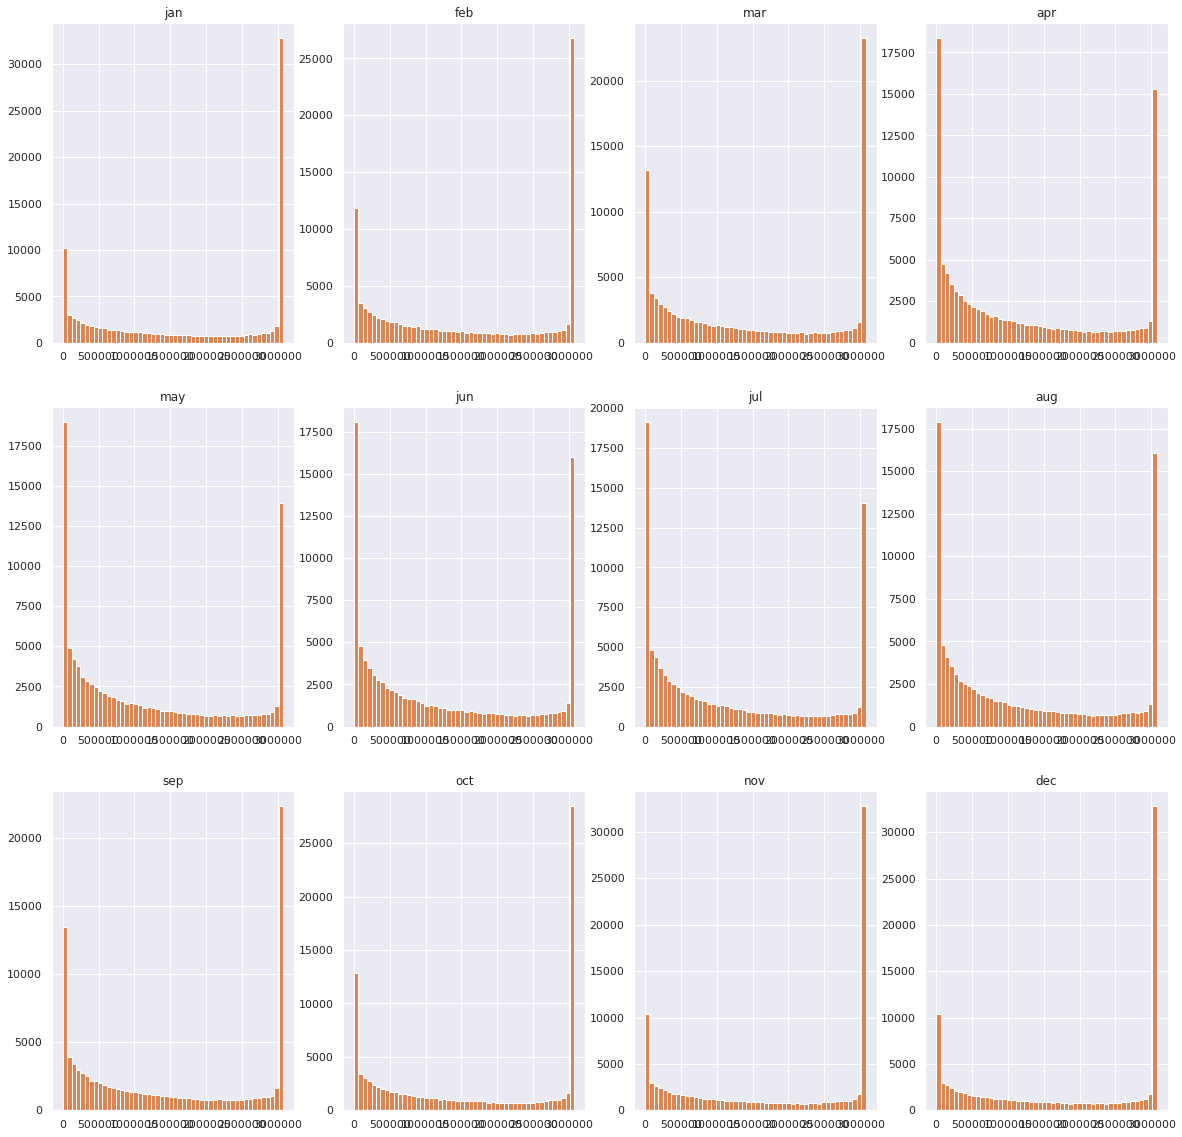

In [28]:
# A) Expected amount of power
i = 1
result = []

for key, wind in hlp.winds.items():

    # Plotting
    plt.subplot(3,4,i)
    i+=1
    plt.hist(wind["wind"], bins=100, density=True)
    plt.gca().set_title(key)

    # Calculated power from the generated wind
    power = P(wind["wind"])
    hist = plt.hist(power, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(power)
    var = np.var(power)
    confidence_interval = 1.96*np.sqrt(var/n)
    
    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)} ± {np.round(confidence_interval, decimals=2)}'})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 a) Truncated U

\begin{tabular}{ll}
\toprule
{} &                  Mean \\
Month &                       \\
\midrule
jan   &  1732294.77 ± 7594.82 \\
feb   &  1567779.96 ± 7594.82 \\
mar   &  1470277.44 ± 7594.82 \\
apr   &  1195282.57 ± 7594.82 \\
may   &  1142059.55 ± 7594.82 \\
jun   &  1219316.25 ± 7594.82 \\
jul   &  1138749.18 ± 7594.82 \\
aug   &  1212232.77 ± 7594.82 \\
sep   &  1446919.71 ± 7594.82 \\
oct   &  1584820.95 ± 7594.82 \\
nov   &  1726977.75 ± 7594.82 \\
dec   &  1733402.27 ± 7594.82 \\
\bottomrule
\end{tabular}



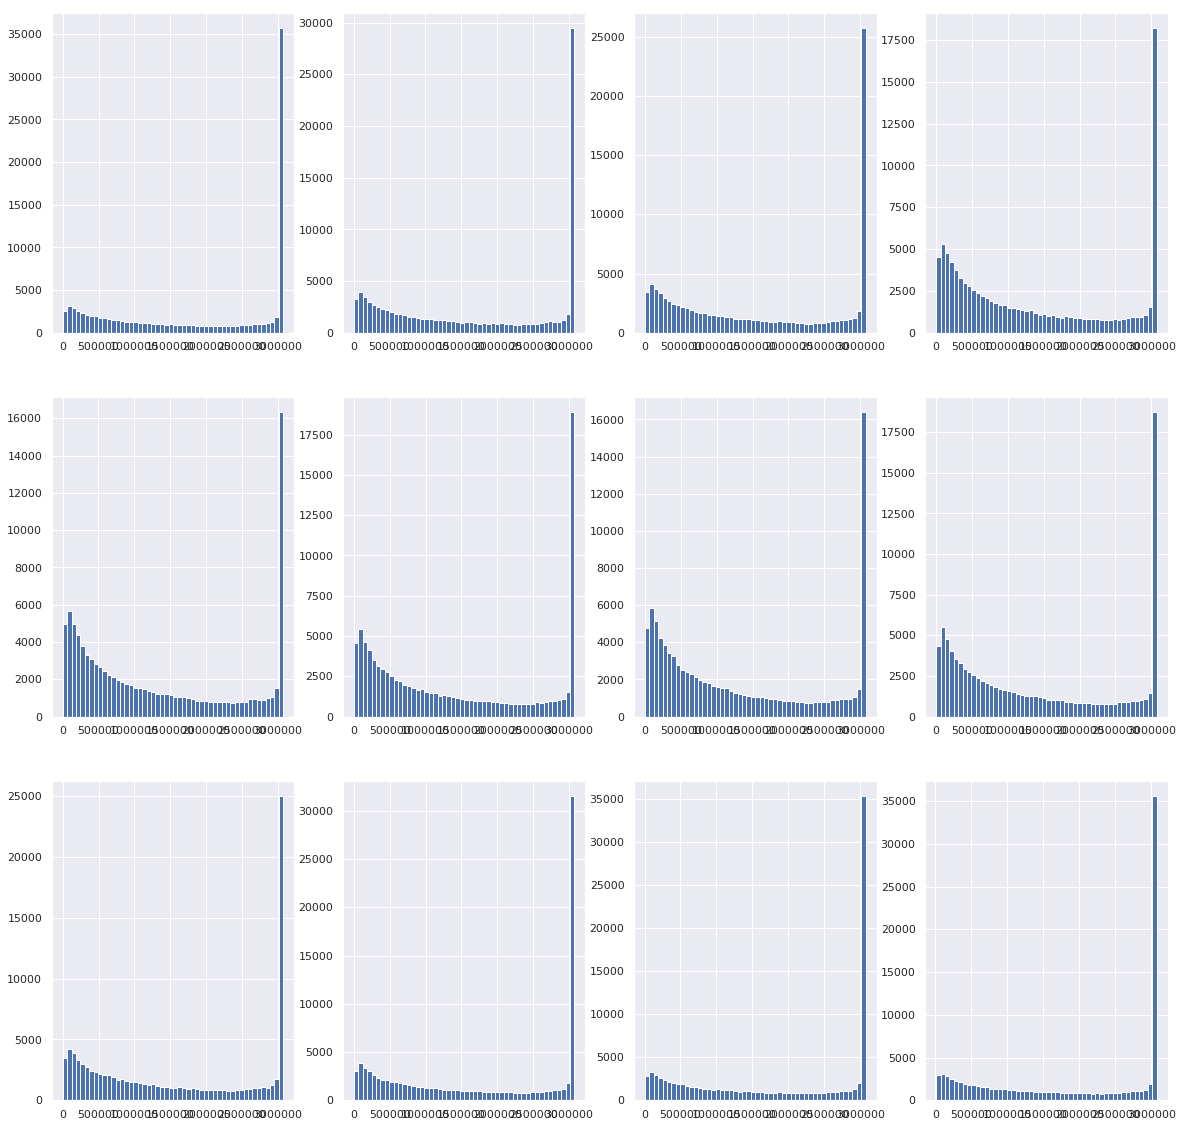

In [30]:
# A) Expected amount of power, truncated version
i = 1

result = []

for key, wind in hlp.winds.items():

    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)

    # Generate uniform data
    u = uniform.rvs(size=n)

    # Fix condition to U
    u = ((F_max-F_min)*u + F_min)

    # Run u through inverse of weibull 
    wind_truncated = wind["dist"].ppf(u)

    # Calculated the power for the truncated wind
    power_trunc = calculate_power(wind_truncated)

    plt.subplot(3,4,i)
    i+=1
    hist = plt.hist(power_trunc, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(power_trunc)*(F_max-F_min)
    var = np.var(power_trunc)*((F_max-F_min)**2)
    confidence_intervall = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)} ± {np.round(confidence_interval, decimals=2)}'})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 b) Importance Sampling

\begin{tabular}{ll}
\toprule
{} &                  Mean \\
Month &                       \\
\midrule
jan   &  1731557.55 ± 2949.96 \\
feb   &  1570593.95 ± 3098.25 \\
mar   &  1470326.55 ± 3456.29 \\
apr   &   1187832.09 ± 3828.6 \\
may   &  1140447.46 ± 2422.68 \\
jun   &  1210403.78 ± 3759.36 \\
jul   &  1142887.21 ± 3907.87 \\
aug   &  1212452.57 ± 3758.43 \\
sep   &  1444957.14 ± 3542.47 \\
oct   &  1586155.22 ± 2753.48 \\
nov   &  1729549.79 ± 2975.65 \\
dec   &  1732797.41 ± 2971.17 \\
\bottomrule
\end{tabular}



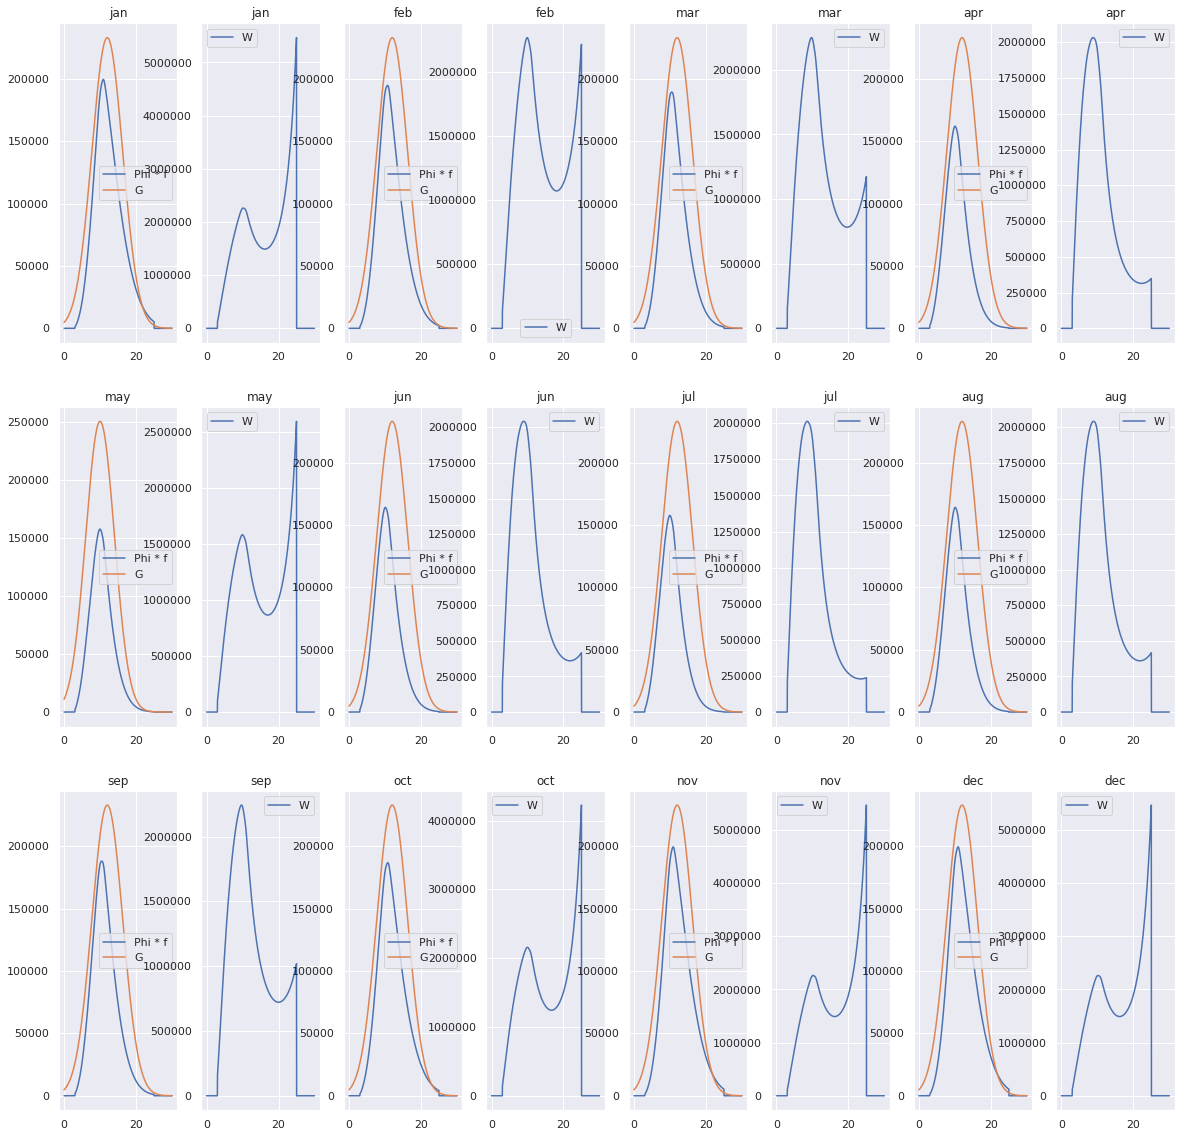

In [61]:
x = np.linspace(0,30, num=n)
i = 1
result = []

g_parameters  = {
        "jan" : [12, 4.3],
        "feb" : [12, 4.3],
        "mar" : [12, 4.3],
        "apr" : [12, 4.3],
        "may" : [10, 4],
        "jun" : [12, 4.3],
        "jul" : [12, 4.3],
        "aug" : [12, 4.3],
        "sep" : [12, 4.3],
        "oct" : [12, 4.3],
        "nov" : [12, 4.3],
        "dec" : [12, 4.3]
    }

for key, wind in hlp.winds.items():

    h = lambda x: P(x)*wind["dist"].pdf(x)

    # Selecting g as a normal distribution
    my = g_parameters[key][0]
    sigma2 = g_parameters[key][1]
    g_scale = 10**6.4
    g_dist = norm(my, sigma2)
    g = lambda x: g_dist.pdf(x)
    
    plt.subplot(3,8,i)
    
    i+=1
    plt.plot(x, h(x), label="Phi * f")
    plt.plot(x, g(x)*g_scale, label="G")
    plt.legend()
    plt.gca().set_title(key)

    plt.subplot(3,8,i)
    i+=1
    plt.plot(x, h(x)/g(x), label="W")
    plt.gca().set_title(key)
    plt.legend()

    X = g_dist.rvs(size=n)

    # Function to evaluate
    s = lambda x: h(x)/g(x)

    # Calculate variance
    mean = np.mean(s(X))
    var = np.var(s(X))
    confidence_interval = 1.96*np.sqrt(var/n)
    
    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)} ± {np.round(confidence_interval, decimals=2)}'})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 c) Antithetic sampling

\begin{tabular}{ll}
\toprule
{} &                  Mean \\
Month &                       \\
\midrule
jan   &  1730742.63 ± 1214.52 \\
feb   &   1570623.03 ± 530.11 \\
mar   &   1468294.12 ± 450.45 \\
apr   &  1189706.43 ± 1131.58 \\
may   &   1139951.6 ± 1249.84 \\
jun   &  1212404.54 ± 1073.24 \\
jul   &  1140285.05 ± 1248.36 \\
aug   &  1213024.21 ± 1071.62 \\
sep   &    1447163.59 ± 487.4 \\
oct   &   1585699.45 ± 660.25 \\
nov   &  1731548.38 ± 1218.42 \\
dec   &  1731985.52 ± 1214.95 \\
\bottomrule
\end{tabular}



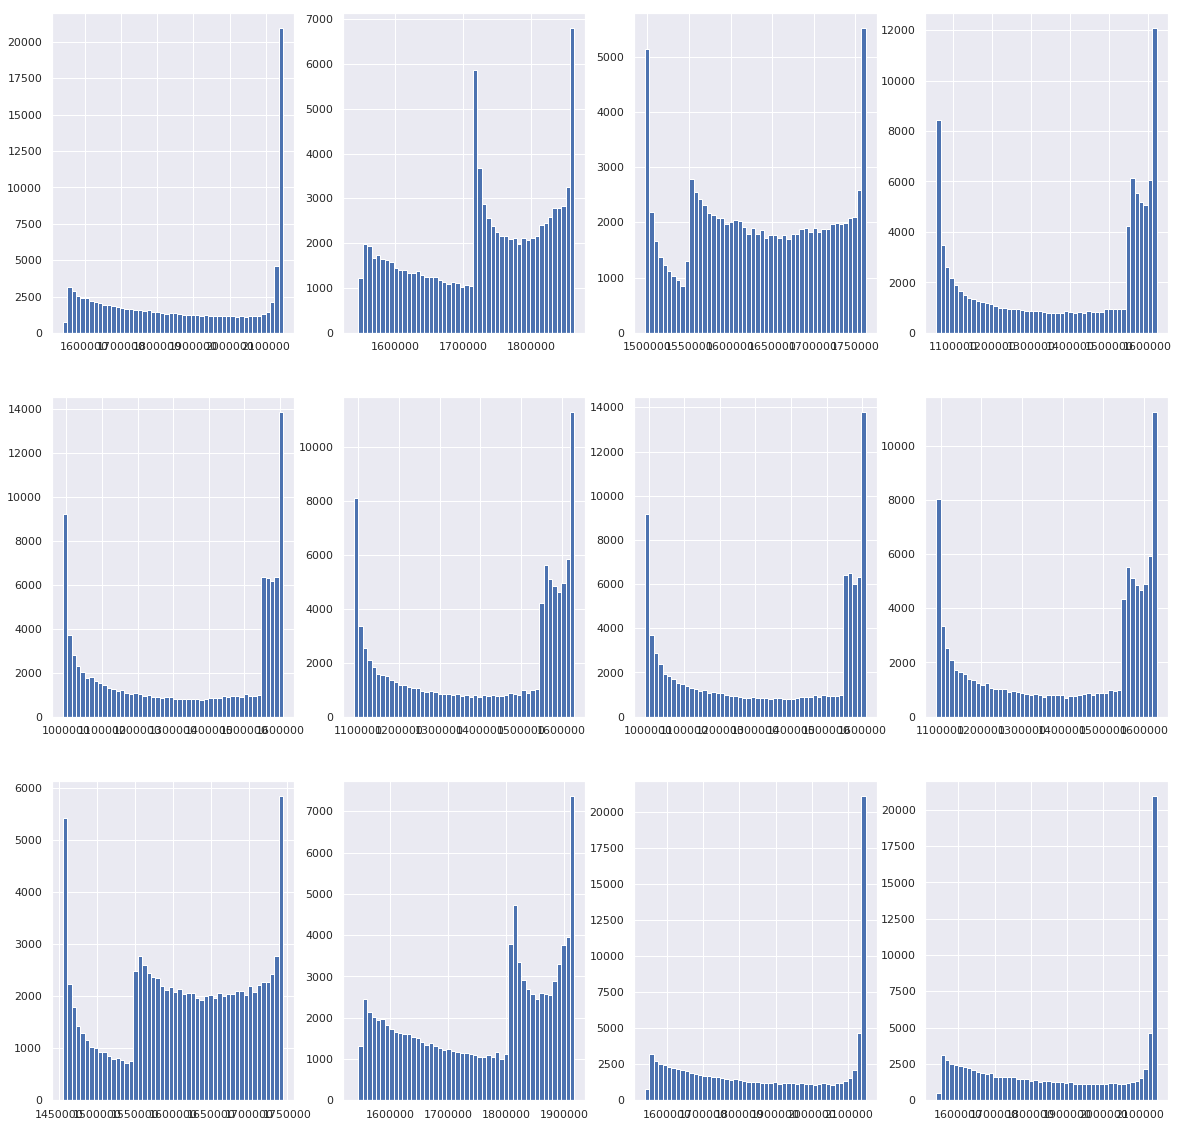

In [38]:
# A) Expected amount of power, truncated version
i = 1
result = []

for key, wind in hlp.winds.items():

    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)

    # Generate uniform data
    u = uniform.rvs(size=n)
    u2 = 1 - u

    # Fix condition to U
    u = ((F_max-F_min)*u + F_min)
    u2 = ((F_max-F_min)*u2 + F_min)

    # Run u through inverse of weibull
    v = P(wind["dist"].ppf(u))
    v2 = P(wind["dist"].ppf(u2))
    
    # Calculated the power for the truncated wind
    w = (v + v2)/2

    plt.subplot(3,4,i)
    i+=1
    hist = plt.hist(w, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(w)*(F_max-F_min)
    var = np.var(w)*((F_max-F_min)**2)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 2)} ± {np.round(confidence_interval, decimals=2)}'})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# 2 d)

In [8]:
# Probability that the turbine delivers power
print(f'Prob for delivering power: {(F_max - F_min)*100}%')

Prob for delivering power: 91.91850832071029%


# 2 e) Estimating power ratio

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


\begin{tabular}{ll}
\toprule
{} &               Mean \\
Month &                    \\
\midrule
jan   &  0.30223 ± 0.00046 \\
feb   &  0.31322 ± 0.00064 \\
mar   &  0.31792 ± 0.00076 \\
apr   &  0.31398 ± 0.00104 \\
may   &   0.31474 ± 0.0011 \\
jun   &  0.31488 ± 0.00101 \\
jul   &   0.31583 ± 0.0011 \\
aug   &   0.3144 ± 0.00101 \\
sep   &  0.31943 ± 0.00078 \\
oct   &   0.30346 ± 0.0006 \\
nov   &  0.30241 ± 0.00046 \\
dec   &  0.30155 ± 0.00047 \\
\bottomrule
\end{tabular}



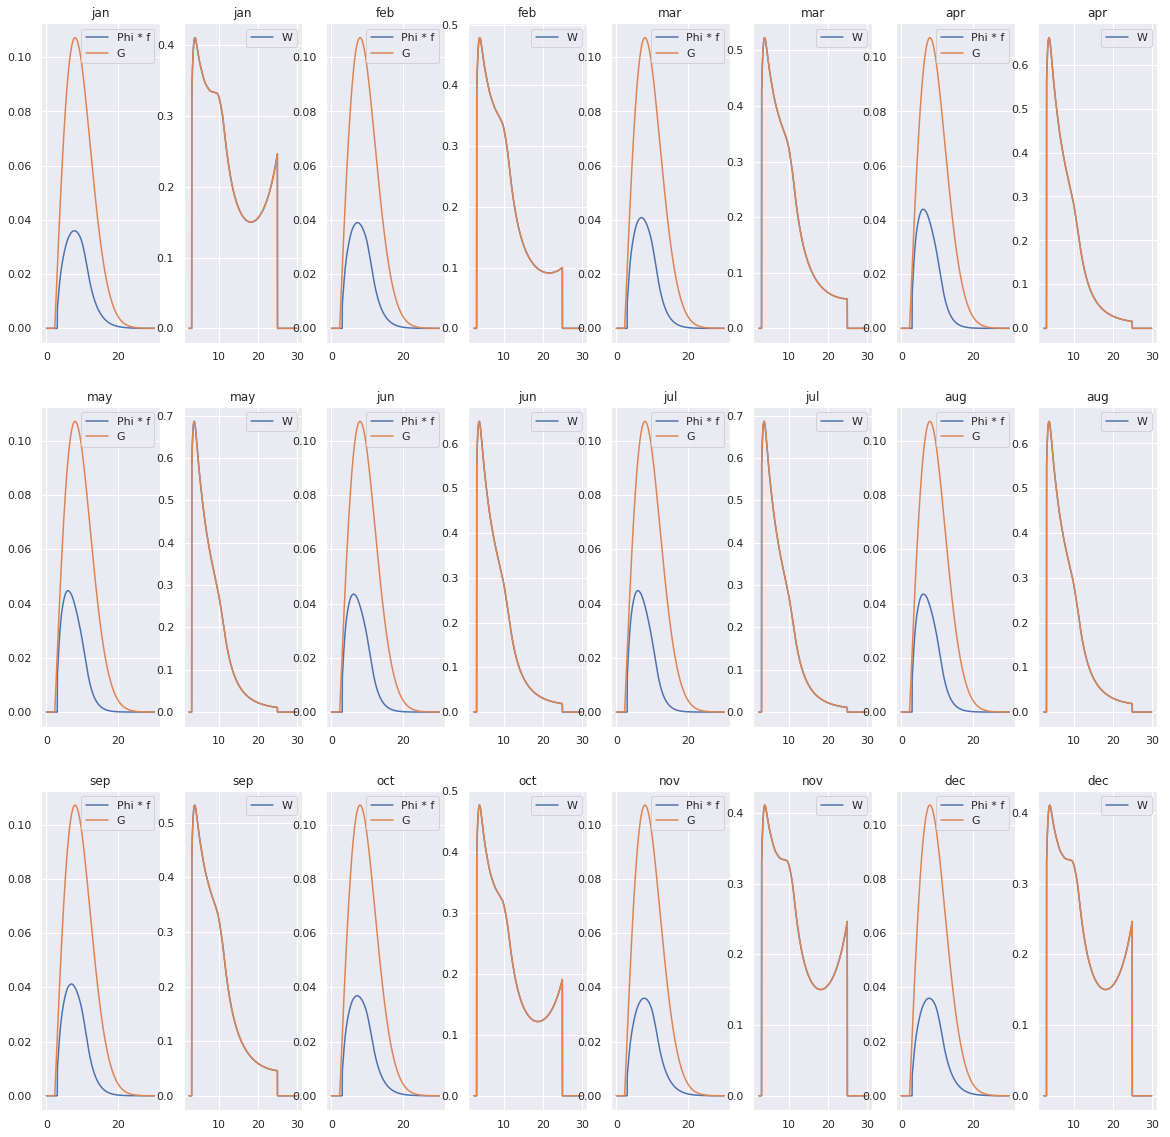

In [67]:
Ptot = lambda v: 1/2*1.225*math.pi*112**2/4*v**3
x = np.linspace(0,30, num=n)

i = 1

result = []

g_parameters  = {
        "jan" : [8, 2, 2.3],
        "feb" : [8, 2, 2.3],
        "mar" : [8, 2, 2.3],
        "apr" : [8, 2, 2.3],
        "may" : [8, 2, 2.3],
        "jun" : [8, 2, 2.3],
        "jul" : [8, 2, 2.3],
        "aug" : [8, 2, 2.3],
        "sep" : [8, 2, 2.3],
        "oct" : [8, 2, 2.3],
        "nov" : [8, 2, 2.3],
        "dec" : [8, 2, 2.3],
    }

for key, wind in hlp.winds.items():
        
    h = lambda x: P(x)/Ptot(x)*wind["dist"].pdf(x)

    # Selecting g as a weibull distribution
    g_dist_lambda = g_parameters[key][0] 
    g_dist_k = g_parameters[key][1] 
    loc = g_parameters[key][2] 
    
    g_dist = weibull_min(g_dist_k, loc = loc, scale = g_dist_lambda)
    g = lambda x: g_dist.pdf(x)

    plt.subplot(3,8,i)
    
    i+=1
    plt.plot(x, h(x), label="Phi * f")
    plt.plot(x, g(x), label="G")
    plt.legend()
    plt.gca().set_title(key)

    plt.subplot(3,8,i)
    i+=1
    plt.plot(x, h(x)/g(x), label="W")
    plt.gca().set_title(key)
    plt.legend()

    plt.plot(x, wind["dist"].pdf(x)*power_ratio(x)/g(x))

    X = g_dist.rvs(size=n)

    # Function to evaluate
    s = lambda x: h(x)/g(x)
    sample = s(X)
    
    # Calculate variance
    mean = np.mean(sample)
    var = np.var(sample)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "Mean": f'{np.round(mean, decimals = 5)} ± {np.round(confidence_interval, decimals=5)}'})
    
print(pd.DataFrame(result).set_index(keys="Month").to_latex())

# Uppgift 3

Mean: 2342841.743443644 ± 6285.6185414323445, Var: 1028451698469.3378


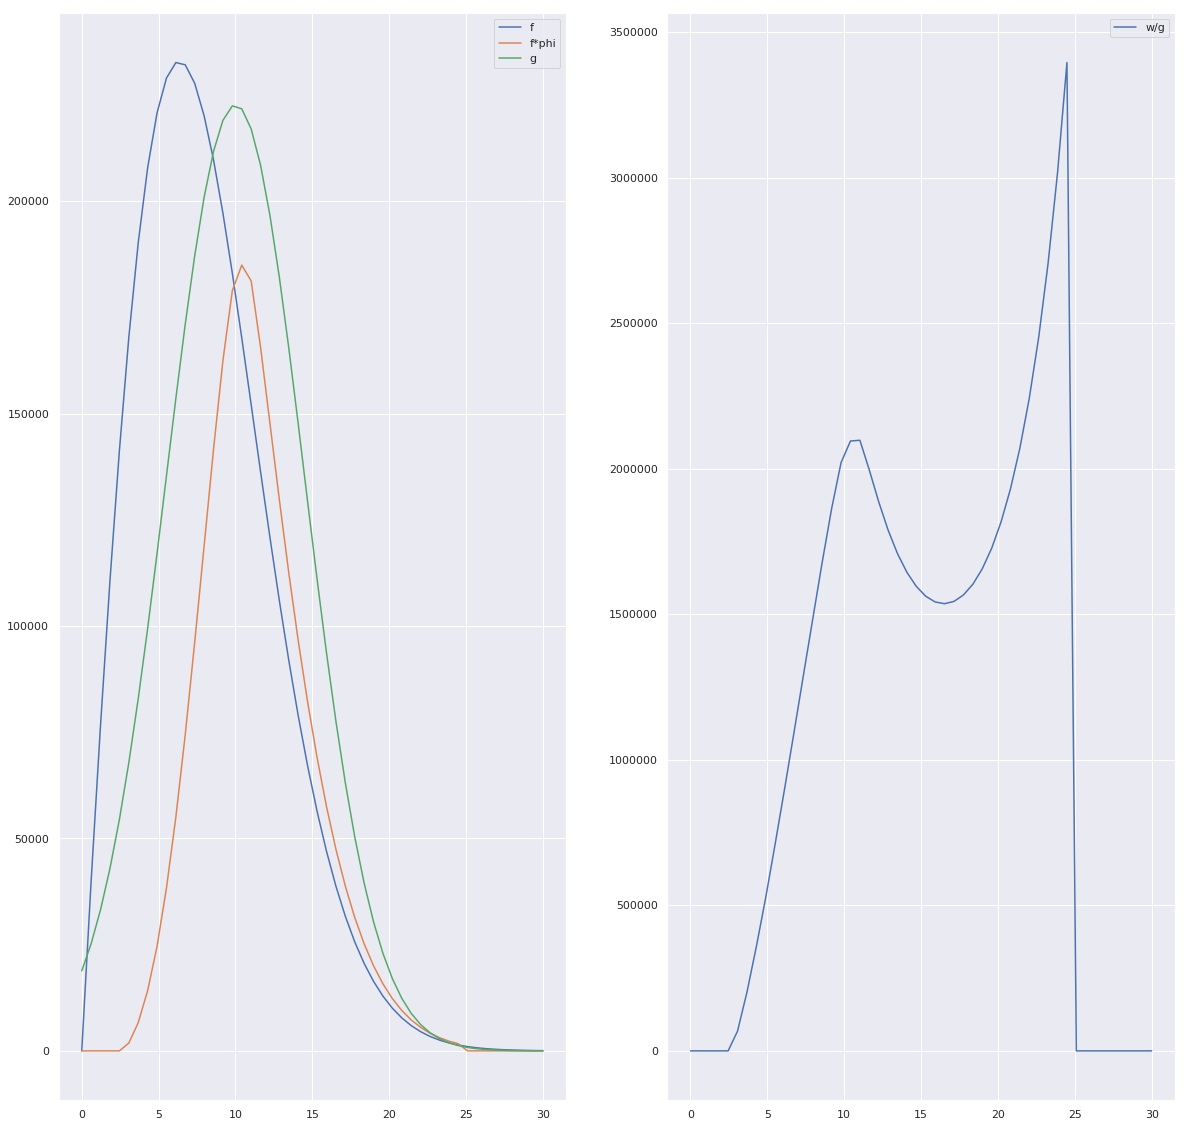

In [48]:
# Uppgift 3
# A
k = 1.96
lamda = 9.13

# Creating the marginal wind distribution
wind_distribution =  weibull_min(k,loc=0, scale=lamda)

# Draw wind 1 and 2
v1 = wind_distribution.rvs(n)
v2 = wind_distribution.rvs(n)

# Selecting g as a normal distribution
my = 10
sigma2 = 4.5
g_scale = 10**6.4
g_dist = norm(my, sigma2)

g = lambda x: g_dist.pdf(x)

x = np.linspace(0, 30, 50)

# Plotting some
plt.subplot(1,2,1)
plt.plot(x, g_scale*wind_distribution.pdf(x), label="f")
plt.plot(x, wind_distribution.pdf(x)*P(x), label="f*phi")
plt.plot(x, g_scale*g(x), label="g")
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, wind_distribution.pdf(x)*P(x)/g(x), label="w/g")
plt.legend()

# Creating sample function
s = lambda x: wind_distribution.pdf(x)*P(x)/g(x)

sample = s(v1) + s(v2)

# Calculate variance
mean = np.mean(sample)
var = np.var(sample)
confidence_interval = 1.96*np.sqrt(var/n)

print(f'Mean: {mean} ± {confidence_interval}, Var: {var}')